In [13]:
# load data
import pandas as pd

# raw string to process path
file_path = r'E:\SA\Yinuo Zhang\Homework\Umea University\0327\faults_data.csv'
# load
fault_data = pd.read_csv(file_path, sep=';')

In [14]:
# data preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
# identify the feature

categorical_features = fault_data.select_dtypes(include=['object']).columns
numeric_features = fault_data.select_dtypes(include=['int64', 'float64']).columns

# whether all feature are under fully considered
assert len(categorical_features) + len(numeric_features) == 34, "Total features do not match."

# create the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # process data features' missing values
            ('scaler', StandardScaler())]), numeric_features),  # standardizing
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # process cat features' missing values
            ('onehot', OneHotEncoder(handle_unknown='ignore'))]), categorical_features),  # onehot encoder cat features
        ],
    remainder='passthrough')

In [15]:
# spilit the dataset, one part is for local device, the other one part is for global 
import numpy as np
from sklearn.model_selection import train_test_split

fault_data = preprocessor.fit_transform(fault_data)
data_local, data_global = train_test_split(fault_data, test_size=0.2, random_state=42)

In [18]:
# implement the Dirichlet Distribution for three local devices: in Non-IID fashion
num_devices = 3

# Concentration parameter
alpha = 0.5

# randomly set proportion for local devices based on Concentration parameter
proportions = np.random.dirichlet([alpha] * num_devices)

# compute the amount of sample for every devices
num_data_per_device = np.floor(proportions * data_local.shape[0]).astype(int)

# generate and shuffle index for local databse
indices = np.arange(data_local.shape[0])
np.random.shuffle(indices)

# distribute the local dataset to three different local devices
device_data_indices = np.split(indices[:num_data_per_device.sum()], np.cumsum(num_data_per_device)[:-1])

device_data = [data_local[device_indices, :] for device_indices in device_data_indices]

# local dataset for training and testing
local_train_data = []
local_test_data = []
for device_data_i in device_data:
    data_train, data_test = train_test_split(device_data_i, test_size=0.2, random_state=42)
    local_train_data.append(data_train)
    local_test_data.append(data_test)

In [19]:
# define autoencoder as deep learning method
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam

# package the autoencoder for both local and global level
def build_autoencoder(data):
    input_dim = data.shape[1]
    
    input_layer = Input(shape=(input_dim,))
    # Encoding layer
    encoded = Dense(16, activation='relu')(input_layer)
    # Decoding Layer
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    
    # Encoder Model
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error') #loss function
    
    return autoencoder

In [26]:
# build a edge deployable deep learning model 
def train_autoencoder(data, epochs=50, batch_size=32, shuffle=True, validation_split=0.2): # package the training process
    
    data = data.toarray() # dense format
    autoencoder = build_autoencoder(data)
    autoencoder.fit(data, data, epochs=epochs, batch_size=batch_size, shuffle=True, validation_split=0.2)
    return autoencoder


# train autoencoder database for every device
autoencoders = [train_autoencoder(data, epochs=100, batch_size=32) for data in local_train_data]

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2420 - val_loss: 0.1525
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1017 - val_loss: 0.0163
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0112 - val_loss: 0.0058
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0039
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0032
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 70/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 71/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 72/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 73/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 74/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 75/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 76/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 77/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 78/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 79/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 80/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0040 - val_loss: 0.0124
Epoch 38/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0041 - val_loss: 0.0120
Epoch 39/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0037 - val_loss: 0.0117
Epoch 40/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - val_loss: 0.0114
Epoch 41/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - val_loss: 0.0111
Epoch 42/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - val_loss: 0.0108
Epoch 43/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - val_loss: 0.0106
Epoch 44/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - val_loss: 0.0104
Epoch 45/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - val_loss: 0.0101
Epoch 46/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - val_loss: 0.0099
Epoch 47/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - val_loss: 0.0097
Epoch 48/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - val_loss: 

Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.2500 - val_loss: 0.2505
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.2495 - val_loss: 0.2502
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2490 - val_loss: 0.2498
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2483 - val_loss: 0.2494
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2476 - val_loss: 0.2490
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2468 - val_loss: 0.2486
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.2458 - val_loss: 0.2481
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.2447 - val_loss: 0.2475
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2435 - val_loss: 0.2469
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2421 - val_loss: 0.2462
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2406 - val_loss: 0.2455
Epoch 17/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2388 - v

Epoch 75/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0202 - val_loss: 0.1027
Epoch 76/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0192 - val_loss: 0.1008
Epoch 77/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0182 - val_loss: 0.0990
Epoch 78/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0173 - val_loss: 0.0973
Epoch 79/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0165 - val_loss: 0.0956
Epoch 80/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0158 - val_loss: 0.0940
Epoch 81/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0151 - val_loss: 0.0924
Epoch 82/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0144 - val_loss: 0.0910
Epoch 83/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0138 - val_loss: 0.0895
Epoch 84/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0132 - val_loss: 0.0881
Epoch 85/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0127 - val_loss: 0.0868
Epoch 86/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0122

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Device 1, mean squared error: 0.001992434283422513


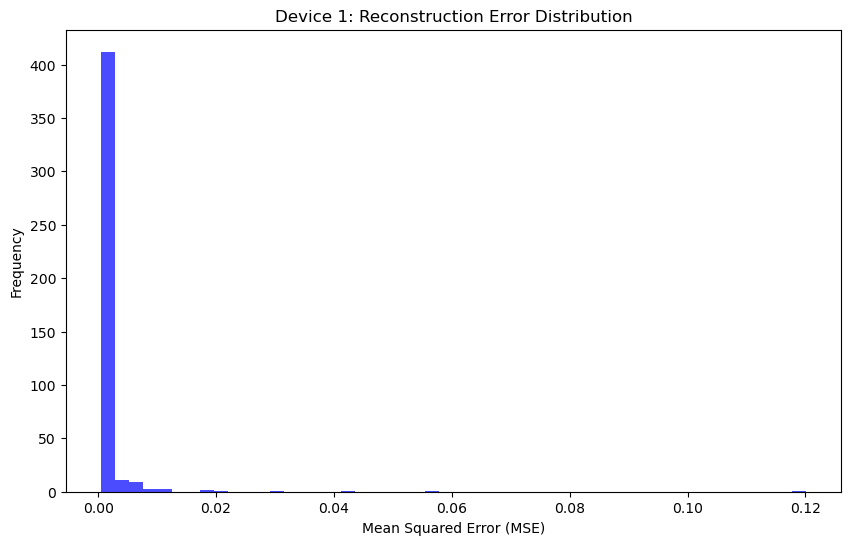

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Device 2, mean squared error: 0.0036234028073429893


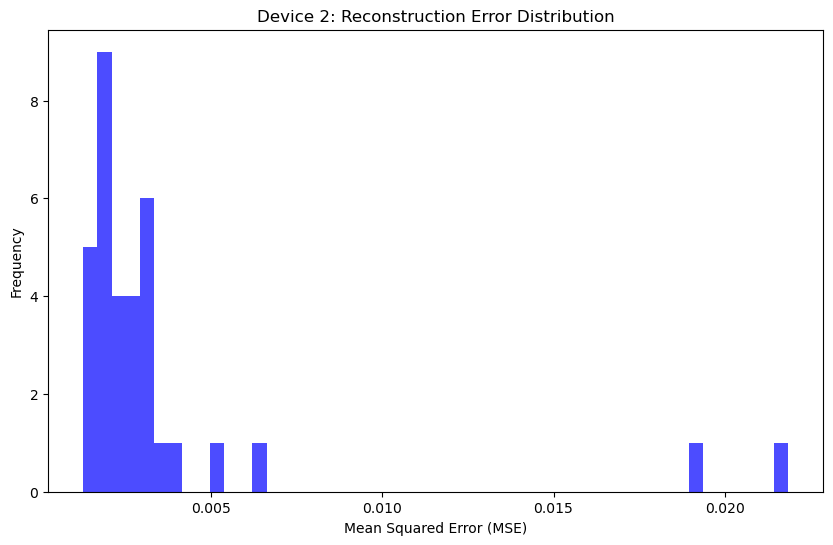

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Device 3, mean squared error: 0.07602568414184413


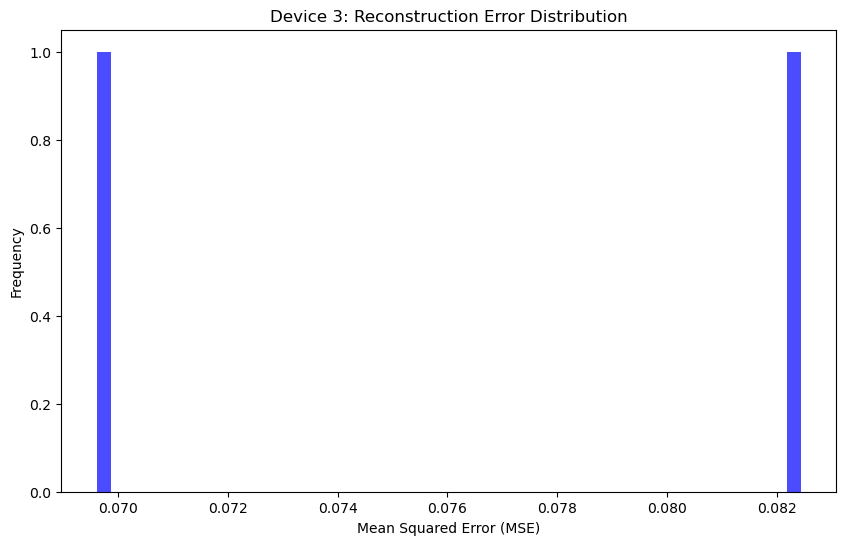

In [27]:
# Fault Detection Process
import matplotlib.pyplot as plt

# define the fault detection function
def detect_faults(autoencoder, data):
    # ensure data is a dense format
    if isinstance(data, np.ndarray):
        pass  # already if numpy
    else:
        data = data.toarray()  # convert sparse matrix to dense format
        
    # reconstruct local test data using autocoder
    reconstructed_data = autoencoder.predict(data)
    # compute reconstruction difference
    mse = np.mean(np.square(data - reconstructed_data), axis=1)
    return mse

# define visualization function
def plot_reconstruction_error_distribution(mse, device_id):
    plt.figure(figsize=(10, 6))
    plt.hist(mse, bins=50, alpha=0.7, color='blue')
    plt.title(f"Device {device_id}: Reconstruction Error Distribution")
    plt.xlabel("Mean Squared Error (MSE)")
    plt.ylabel("Frequency")
    plt.show()

# Fault Detection on every device test!
for i, (autoencoder, test_data) in enumerate(zip(autoencoders, local_test_data)):
    mse = detect_faults(autoencoder, test_data)
    print(f"Device {i+1}, mean squared error: {np.mean(mse)}")
    plot_reconstruction_error_distribution(mse, i+1)

In [28]:
# fault judgement based on threshold value
def identify_potential_faults(mse, percentile=95):
    sorted_mse = np.sort(mse)  # sort
    threshold = np.percentile(sorted_mse, percentile)  # percentile
    print(f"Threshold for potential faults: {threshold}")
    potential_faults = mse > threshold
    return potential_faults, threshold

# identify the number of fault sample for every device
for i, (autoencoder, test_data) in enumerate(zip(autoencoders, local_test_data)):
    mse = detect_faults(autoencoder, test_data)
    potential_faults, threshold = identify_potential_faults(mse)
    print(f"Device {i+1}, Potential faults count: {np.sum(potential_faults)}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Threshold for potential faults: 0.004967241629988009
Device 1, Potential faults count: 23
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
Threshold for potential faults: 0.010989731558431862
Device 2, Potential faults count: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Threshold for potential faults: 0.08179584296118447
Device 3, Potential faults count: 1


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.2498 - val_loss: 0.2469
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2424 - val_loss: 0.2300
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2184 - val_loss: 0.1926
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1713 - val_loss: 0.1379
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1097 - val_loss: 0.0835
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0575 - val_loss: 0.0471
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0290 - val_loss: 0.0284
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0155 - val_loss: 0.0198
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0098 - val_loss: 0.0155
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0075 - val_loss: 0.0130
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0058 - val_loss: 0.0115
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0050 - val

Epoch 20/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - val_loss: 0.0073
Epoch 21/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028 - val_loss: 0.0071
Epoch 22/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - val_loss: 0.0070
Epoch 23/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - val_loss: 0.0068
Epoch 24/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - val_loss: 0.0067
Epoch 25/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - val_loss: 0.0066
Epoch 26/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - val_loss: 0.0065
Epoch 27/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - val_loss: 0.0065
Epoch 28/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - val_loss: 0.0064
Epoch 29/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022 - val_loss: 0.0063
Epoch 30/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - val_loss: 0.0063
Epoch 31/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020

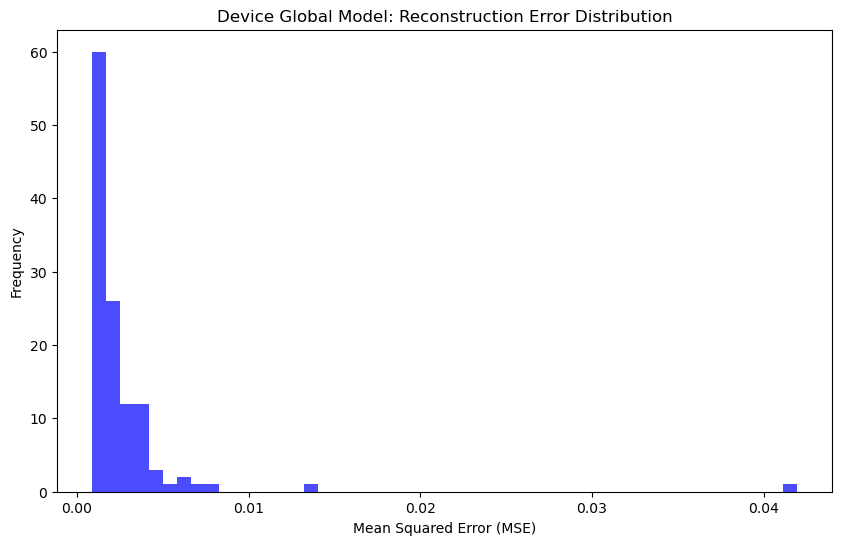

Threshold for potential faults: 0.005110032351874654
Global model, Potential faults count: 6


In [30]:
# global model (edge server): integration

# initialize
data_global_train, data_global_test = train_test_split(data_global, test_size=0.2, random_state=42)

# train process
train_autoencoder(data_global_train)

# test
global_test_mse = detect_faults(train_autoencoder(data_global_train), data_global_test)

# compute the global testing error distribution
plot_reconstruction_error_distribution(global_test_mse, "Global Model")

# identify potential faults for global
potential_faults_global, _ = identify_potential_faults(global_test_mse)
print(f"Global model, Potential faults count: {np.sum(potential_faults_global)}")